# UvA : Model Based Decision Making 
## Asignement 3 

By Māra Učelniece and Noah Zuijderwijk

15th December 2025

Amsterdam

In [1]:
# Imports 
from new_core import *
from new_plotting import *
from new_policy_implement import * 

print("All functions have been imported ;)")

C:\Users\Mara\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Mara\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


All functions have been imported ;)


### Runing the whole experiment 


=== Running heatmap analysis ===
Starting heatmap sweep (this may take some time)...
Heatmap saved to: output_ev_final_analysis\heatmap_final_adoption.png

=== Running sensitivity analysis ===
Starting sensitivity sweep over beta_I ...
Sensitivity plot saved to: output_ev_final_analysis\sensitivity_betaI_mean_with_CI_corrected_X0.png

=== Running phase trajectory plots ===
Creating combined phase plot...
Combined phase and time-series plots saved to: output_ev_final_analysis
Running network & outcome structure analysis...
Running policy / seeding & infrastructure shock experiments...
Running Baseline 1: Random Seeding, No Shocks...
Running Baseline 2: Targeted Seeding, No Shocks...
Running Scenario: Random Seeding, Shock at t=25...
Running Scenario: Random Seeding, Shock at t=50...
Running Scenario: Random Seeding, Shock at t=75...
Running Scenario: Targeted Seeding, Shock at t=25...
Running Scenario: Targeted Seeding, Shock at t=50...
Running Scenario: Targeted Seeding, Shock at t=75

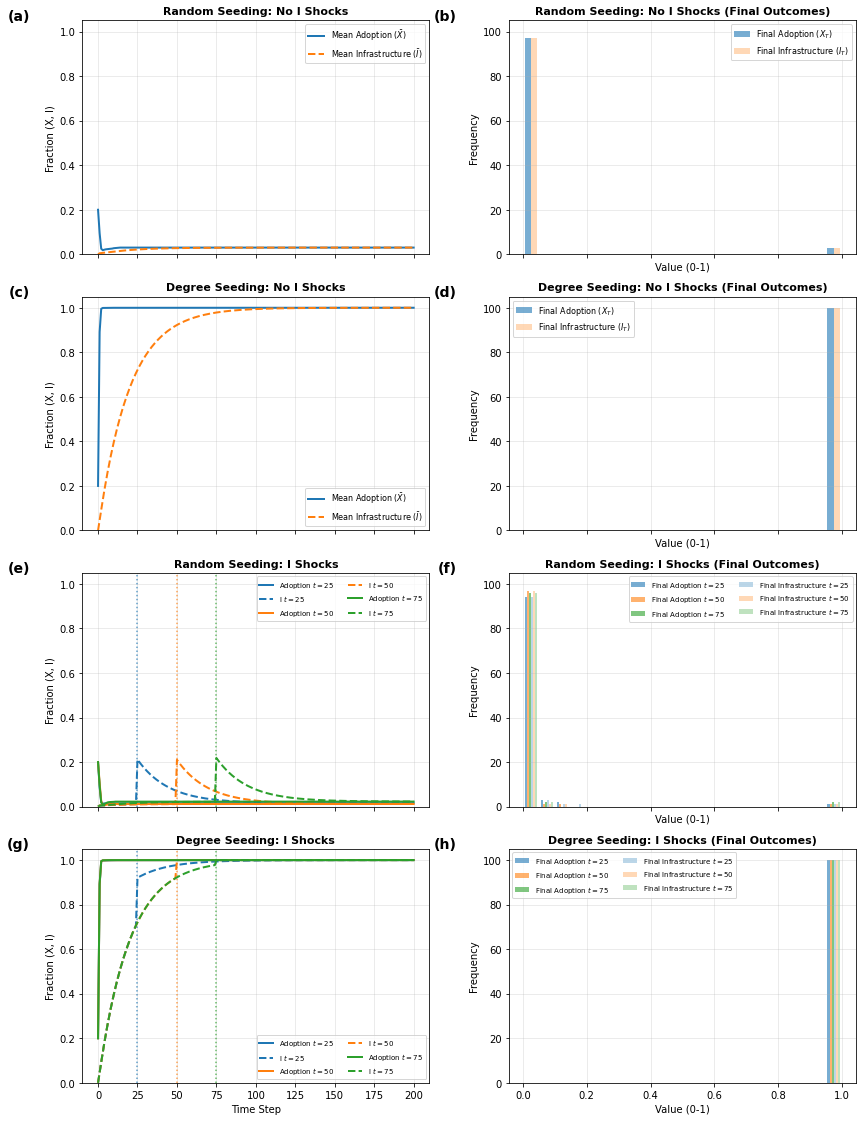

All experiments completed successfully.
Artifacts written to: output_ev_final_analysis


In [2]:
def main():
    import os
    import numpy as np
    import pandas as pd

    # ============================================================
    #  OUTPUT DIRECTORY
    # ============================================================
    out_dir = "output_ev_final_analysis"
    os.makedirs(out_dir, exist_ok=True)

    # ============================================================
    #  GLOBAL MODEL PARAMETERS
    # ============================================================
    a0 = 2.0
    b = 1.0
    g_I = 0.05
    beta_I_baseline = 2.0
    tau = 1.0
    T = 200

    network_type = "BA"   # "ER", "WS", "BA"
    n_nodes = 200
    p = 0.05
    m = 2
    strategy_choice_func = "imitate"

    # ============================================================
    #  HEATMAP CONFIG
    # ============================================================
    X0_grid = np.linspace(0.1, 0.5, 3)
    I0_grid = np.linspace(0.1, 0.5, 3)
    trials_per_cell = 1
    seed_base_heatmap = 42

    # ============================================================
    #  SENSITIVITY CONFIG
    # ============================================================
    beta_vals = np.linspace(0.0, 4.0, 20)
    X0_sens = [0.2, 0.3, 0.4, 0.5]
    sensitivity_trials = 8
    seed_base_sensitivity = 42

    # ============================================================
    #  PHASE TRAJECTORY CONFIG
    # ============================================================
    phase_cases = [
        (0.00, 0.20),
        (0.20, 0.20),
        (0.50, 0.20),
        (0.00, 0.40),
        (0.20, 0.40),
        (0.50, 0.40),
    ]
    seed_base_phase = 42

    # ============================================================
    #  POLICY / SEEDING & INFRASTRUCTURE SHOCK CONFIG
    # ============================================================
    TRIALS = 100
    STEPS = 200
    PARAMS = dict(
        a0=a0,
        beta_I=beta_I_baseline,
        b=b,
        g_I=g_I,
        I0=0.0,
        X0_frac=0.2,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        func=strategy_choice_func,
    )
    shock_times = [25, 50, 75]
    shock_amount = 0.2

    # ============================================================
    #  1. HEATMAP ANALYSIS
    # ============================================================
    print("\n=== Running heatmap analysis ===")
    X0_vals, I0_vals, H = run_heatmap_analysis(
        out_dir,
        X0_grid,
        I0_grid,
        a0,
        beta_I_baseline,
        b,
        g_I,
        n_nodes,
        p,
        m,
        T,
        trials_per_cell,
        network_type,
        strategy_choice_func,
        tau,
        seed_base_heatmap,
    )

    # ============================================================
    #  2. SENSITIVITY ANALYSIS
    # ============================================================
    print("\n=== Running sensitivity analysis ===")
    X0_list, betas, mean_vals = run_sensitivity_analysis(
        out_dir,
        beta_vals,
        X0_sens,
        0.05,
        a0,
        b,
        g_I,
        n_nodes,
        p,
        m,
        T,
        sensitivity_trials,
        network_type,
        strategy_choice_func,
        tau,
        seed_base_sensitivity,
    )

    # ============================================================
    #  3. PHASE TRAJECTORIES
    # ============================================================
    print("\n=== Running phase trajectory plots ===")
    trajs = run_phase_plots(
        out_dir,
        phase_cases,
        a0,
        beta_I_baseline,
        b,
        g_I,
        n_nodes,
        p,
        m,
        T,
        network_type,
        strategy_choice_func,
        tau,
        seed_base_phase,
    )

    # ============================================================
    #  4. NETWORK & OUTCOME STRUCTURE ANALYSIS 
    # ============================================================
    print("Running network & outcome structure analysis...")
    structure_metrics = []

    for (X0, I0), data in trajs.items():
        X_traj = data["X"]
        metrics = {
            "X0": X0,
            "I0": I0,
            "final_adoption": calculate_final_adoption(X_traj),
            "adoption_rate": calculate_adoption_rate(X_traj),
            "time_to_80pct": time_to_reach_threshold(X_traj, 0.8),
            "stable_high_adoption": is_high_adoption_equilibrium(X_traj, 0.8),
        }
        structure_metrics.append(metrics)

    structure_df = pd.DataFrame(structure_metrics)
    structure_df.to_csv(
        os.path.join(out_dir, "network_outcome_structure_metrics.csv"),
        index=False
    )

    # ============================================================
    #  5. POLICY / SEEDING & INFRASTRUCTURE SHOCKS
    # ============================================================
    print("Running policy / seeding & infrastructure shock experiments...")
    policy_results = execute_and_plot(
        TRIALS,
        STEPS,
        PARAMS,
        shock_times,
        shock_amount,
        run_batch,
        lighten_color,
        get_key_prefix
    )

    # ============================================================
    #  6. ARTIFACT INDEXING
    # ============================================================
    new_artifacts = {
        "policy_shock_plot": os.path.join(out_dir, "policy_shock_overview.png"),
    }

    artifact_index = {
        "heatmap_png": os.path.join(out_dir, "heatmap_final_adoption.png"),
        "heatmap_csv": os.path.join(out_dir, "heatmap_final_adoption.csv"),
        "sensitivity_png": os.path.join(out_dir, "sensitivity_betaI_mean_with_CI_corrected_X0.png"),
        "phase_plot": os.path.join(out_dir, "phaseplot.png"),
        "network_structure_csv": os.path.join(out_dir, "network_outcome_structure_metrics.csv"),
    }
    artifact_index.update(new_artifacts)

    pd.DataFrame(
        list(artifact_index.items()),
        columns=["artifact", "path"]
    ).to_csv(os.path.join(out_dir, "artifact_index.csv"), index=False)

    print("All experiments completed successfully.")
    print("Artifacts written to:", out_dir)


if __name__ == "__main__":
    main()
